In [1]:
import os
import numpy as np
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize, ZScaleInterval)
%matplotlib notebook

Resampling factor

In [2]:
factor = 4 

Open **png** image using PIL

In [3]:
img = Image.open('m31.png', 'r')

In [4]:
img.size

(485, 550)

Crop the image to a size based on the resampling factor

In [5]:
aux_dim = [(n // factor) * factor for n in img.size]

For PIL the coordinate system starts at the left-top position

In [6]:
left, top, right, bottom = 0, 0, aux_dim[0], aux_dim[1]
img = img.crop(box=(left, top, right, bottom))

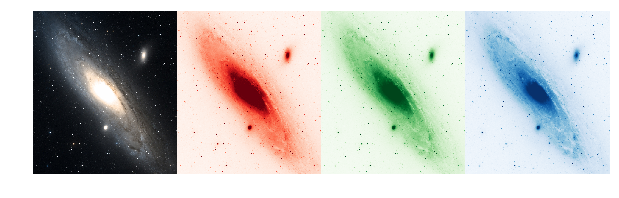

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(8, 3))

cmaps = ['Reds', 'Greens', 'Blues']
for i, axis in enumerate(ax.flatten()):
    if i == 0:
        axis.imshow(np.asarray(img))
    else:
        axis.imshow(np.asarray(img.split()[i - 1]), cmap=cmaps[i - 1])
    axis.axis('off')
plt.subplots_adjust(left=0, bottom=0, top=1, right=1, wspace=0)

plt.savefig('resized_bands.png', dpi=300, format='png')

Now, do the subsampling to a lower resolution

In [8]:
dim_bin = [n // factor for n in aux_dim]
img_bin = img.resize(dim_bin, resample=Image.LANCZOS)

Plotting the subsampled image

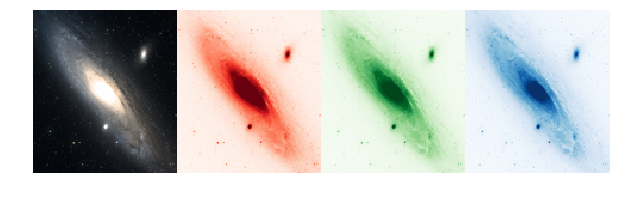

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(8, 3))

cmaps = ['Reds', 'Greens', 'Blues']
for i, axis in enumerate(ax.flatten()):
    if i == 0:
        axis.imshow(np.asarray(img_bin))
    else:
        axis.imshow(np.asarray(img_bin.split()[i - 1]), cmap=cmaps[i - 1])
    axis.axis('off')
plt.subplots_adjust(left=0, bottom=0, top=1, right=1, wspace=0)

plt.savefig('subsampled_bands.png', dpi=300, format='png')

Define a finer grid, increasing the number of points using the sampling factor

In [10]:
N_dim = [factor * k for k in dim_bin]
xx, yy = np.meshgrid(np.linspace(0, dim_bin[1], N_dim[1]), 
                     np.linspace(0, dim_bin[0], N_dim[0]),
                     sparse=False, indexing='ij')

We need to also define the subsampled grid

In [11]:
xx_ini, yy_ini = np.mgrid[0:dim_bin[1], 0:dim_bin[0]]
points = np.vstack([yy_ini.ravel(), xx_ini.ravel()])

In [12]:
xx.shape, xx_ini.shape

((548, 484), (137, 121))

At  this point we need to work separately with the red, green, and blue bands

In [13]:
values_r = np.asarray(img_bin.split()[0]).flatten()
values_g = np.asarray(img_bin.split()[1]).flatten()
values_b = np.asarray(img_bin.split()[2]).flatten()

In [14]:
values_r.shape, points.shape

((16577,), (2, 16577))

We then interpolate the subsampled grid into a finer, using the values pixel values for interpolation

In [15]:
interp_img = [interpolate.griddata(points.T, v, (yy, xx), method='cubic') 
              for v in [values_r, values_g, values_b]]
# Normalize byt the number of subpixels each pixel is divided
# interp_img /= np.power(factor, 2)

In [16]:
arr_rec = np.dstack([*interp_img])
arr_rec /= 255.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


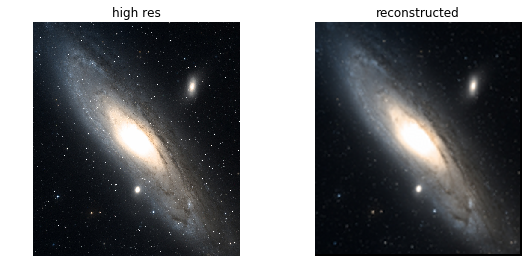

In [17]:
arr_rec.shape
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img)
ax[1].imshow(arr_rec)
ax[0].set_title('high res')
ax[1].set_title('reconstructed')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()

plt.savefig('reconstructed.png', dpi=300, format='png')

/Users/fco/anaconda3/lib/python3.6/site-packages/astropy/visualization/stretch.py:112: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/fco/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


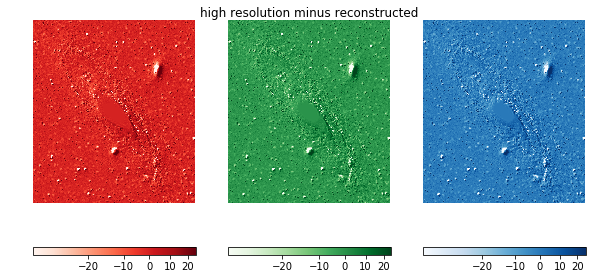

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
cmaps = ['Reds', 'Greens', 'Blues']
for j, axis in enumerate(ax.flatten()):
    diff_img = np.asarray(img.split()[j]) - interp_img[j]
    im_norm = ImageNormalize(diff_img, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    tmp = axis.imshow(diff_img, norm=im_norm, cmap=cmaps[j])
    plt.colorbar(tmp, ax=axis, orientation='horizontal')
    axis.axis('off')

plt.subplots_adjust(top=0.99, left=0.02, right=0.98, bottom=0)
plt.suptitle('high resolution minus reconstructed')

plt.savefig('difference_bands.png', dpi=300, format='png')